<a href="https://colab.research.google.com/github/Sanz-8/Jet-Classification-using-Machine-Learning/blob/main/Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -U "datasets>=2.14.6"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Activation,BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from huggingface_hub import login
from google.colab import userdata

token=userdata.get('HF_TOKEN')
login(token=token)


In [5]:
from datasets import load_dataset
ds = load_dataset("dl4phys/top_tagging_images")

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/912 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/134M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/44.7M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/44.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1211000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/403000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/404000 [00:00<?, ? examples/s]

In [6]:
def preprocess_pil(pil_image,target_size=(224, 224)):

    pil_image = pil_image.convert("RGB")

    pil_image = pil_image.resize(target_size)

    img_array = np.array(pil_image)

    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    return img_tensor

In [7]:
train_indices=np.random.choice(1200000,100000,replace=False)
val_indices=np.random.choice(400000,50000,replace=False)
test_indices=np.random.choice(400000,50000,replace=False)


In [8]:
def preprocess_generator(data_type,indices):
    for (img,lbl) in zip(ds[data_type][indices]['image'],ds[data_type][indices]['label']):
        x = preprocess_pil(img)
        yield preprocess_input(x),lbl


In [9]:
train_ds = tf.data.Dataset.from_generator(
    lambda:preprocess_generator('train',train_indices),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).cache().repeat().batch(256).prefetch(tf.data.AUTOTUNE)


In [10]:
val_ds = tf.data.Dataset.from_generator(
    lambda:preprocess_generator('validation',val_indices),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(256).prefetch(tf.data.AUTOTUNE)


In [11]:
test_ds = tf.data.Dataset.from_generator(
    lambda:preprocess_generator('test',test_indices),
    output_signature=(
        tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
).batch(256).prefetch(tf.data.AUTOTUNE)


In [12]:
res_model=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
for l in res_model.layers[:170]:
  l.trainable=False

In [14]:
print(len(res_model.layers))

175


In [15]:
for l in res_model.layers[160:]:
  print(l.trainable)

False
False
False
False
False
False
False
False
False
False
True
True
True
True
True


In [ ]:
model=Sequential()
model.add(res_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))


In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-5),loss='binary_crossentropy',metrics=['accuracy'])

In [16]:
reduce_alpha= ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)
stop_early=EarlyStopping(monitor='val_accuracy',patience=3,restore_best_weights=True)

In [22]:
hist=model.fit(train_ds, validation_data=val_ds,epochs=20,steps_per_epoch=100_000//256,callbacks=[reduce_alpha,stop_early])

Epoch 1/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 272s 661ms/step - accuracy: 0.8085 - loss: 0.4297 - val_accuracy: 0.8488 - val_loss: 0.3454 - learning_rate: 1.0000e-05
Epoch 2/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 252s 648ms/step - accuracy: 0.8320 - loss: 0.3844 - val_accuracy: 0.8568 - val_loss: 0.3273 - learning_rate: 1.0000e-05
Epoch 3/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 251s 646ms/step - accuracy: 0.8422 - loss: 0.3624 - val_accuracy: 0.8632 - val_loss: 0.3160 - learning_rate: 1.0000e-05
Epoch 4/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 252s 648ms/step - accuracy: 0.8481 - loss: 0.3480 - val_accuracy: 0.8663 - val_loss: 0.3080 - learning_rate: 1.0000e-05
Epoch 5/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 252s 647ms/step - accuracy: 0.8538 - loss: 0.3382 - val_accuracy: 0.8711 - val_loss: 0.3010 - learning_rate: 1.0000e-05
Epoch 6/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 251s 645ms/step - accuracy: 0.8595 - loss: 0.3268 - val_accuracy: 0.8732 - val_loss: 0.2958 - learning_rate: 1.0000e-05
Epoch 7/20
390/390 ━━━━━━━━━━━━━━━━━━━━ 

In [17]:
model_1=Sequential()
model_1.add(res_model)
model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(256))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64))
model_1.add(BatchNormalization())
model_1.add(Activation('relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(1,activation='sigmoid'))


In [18]:
model_1.compile(optimizer=Adam(learning_rate=1e-3),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history=model_1.fit(train_ds,validation_data=val_ds,epochs=10, steps_per_epoch=100_000//265, callbacks=[reduce_alpha,stop_early])

Epoch 1/10
 39/377 ━━━━━━━━━━━━━━━━━━━━ 10:23 2s/step - accuracy: 0.7269 - loss: 0.6198

# Datasets(100k)
alpha=1e-5,epochs =5,Trainable layer[165:],training_accuracy=0.8837, validation accuracy= 0.8893 and test_accuracy=0.8877  
alpha=1e-5,epochs=5,Trainable layer[150:],training_accuracy=0.9025, validation accuracy= 0.8937 and test_accuracy=0.892  
alpha=1e-5, epochs=9,Trainable layer[150:],training_accuracy=0.9254, validation accuracy= 0.8932 and test_accuracy=0.89576


# Datasets(200k)
alpha=1e-6,epochs =5,Trainable layer[165:],training_accuracy=0.8837, validation accuracy= 0.8893 and test_accuracy=0.8877  

In [ ]:
y_hat=model.predict(test_ds)

196/196 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step


In [ ]:
y_hat=(y_hat>=0.5).astype(int)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(ds['test'][test_indices]['label'],y_hat))

0.89576


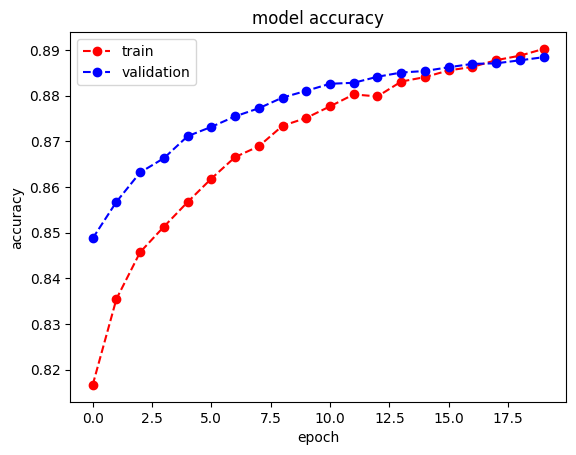

In [31]:
plt.plot(hist.history['accuracy'],'ro',linestyle='dashed')
plt.plot(hist.history['val_accuracy'],'bo',linestyle='dashed')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [23]:
#Saving the model on the drive
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/my_models/model_res.h5')


Mounted at /content/drive


In [ ]:
22.51